*****Stock Price Prediction Using LSTM Deep Learning*****

Samuel I Kigamba

Master of Science Data Science (MSDS), City University of New York (CUNY)

Samuel I Kigamba, December 2021

igukusamuel@gmail.com

In [80]:
#import packages
import pandas as pd
import numpy as np

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

We will first load the dataset and define the target variable for the problem

In [81]:
#read the file
df = pd.read_csv('AMZN.csv')

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500


In [82]:
print('\n Shape of the data:')
print(df.shape)


 Shape of the data:
(2515, 7)


There are multiple variables in the dataset – date, open, high, low, close, adj Close and Volume

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High and Low represent the maximum and minimum price of the share for the day.
Volume is the number of shares bought or sold in the day

**Note that the stock market is closed on weekends and public holidays**

In [83]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

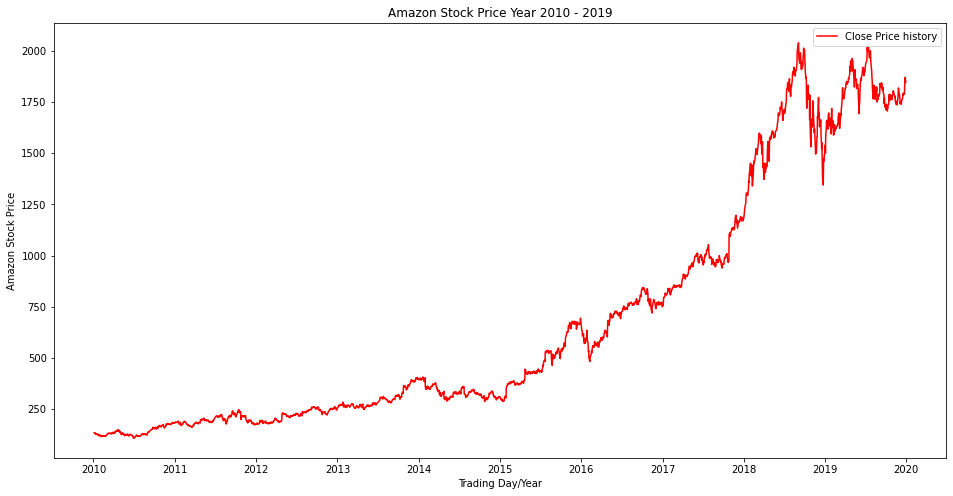

In [84]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history', color = 'red')
plt.title('Amazon Stock Price Year 2010 - 2019')
plt.xlabel('Trading Day/Year')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()

In the upcoming sections, we will:

1. Explore these variables, and

2. Attempt to use different techniques to predict the daily closing price of the stock price for Amazon.com shares. 

Note that the models developed could be used to predict the shares of any company

***Long Short Term Memory (LSTM)***

**Introduction**

LSTM models belong to the class of recurrent neural networks (RNNs), which means they have a typography of inter-neuronal connections that contain at least one cycle (Medsker, 2000 p. 82). They are thus specifically designed to learn long-tern dependencies and can overcome the previously inherent problems of RNNs, that is, vanishing and exploding gradients (Sak et al., 2014).

LSTM has three gates:

The input gate: The input gate adds information to the cell state

The forget gate: It removes the information that is no longer required by the model

The output gate: Output Gate at LSTM selects the information to be shown as output

In [85]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [86]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [87]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:1500,:]
valid = dataset[1500:,:]

In [88]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(50,len(train)):
    x_train.append(scaled_data[i-50:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [89]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1450/1450 - 22s - loss: 2.1194e-04 - 22s/epoch - 15ms/step


In [90]:
#predicting prices, using past 50 from the train data
inputs = new_data[len(new_data) - len(valid) - 50:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(50,inputs.shape[0]):
    X_test.append(inputs[i-50:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

***Results and Plot***

C:\Users\iguku\AppData\Local\Temp/ipykernel_8940/1998286524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


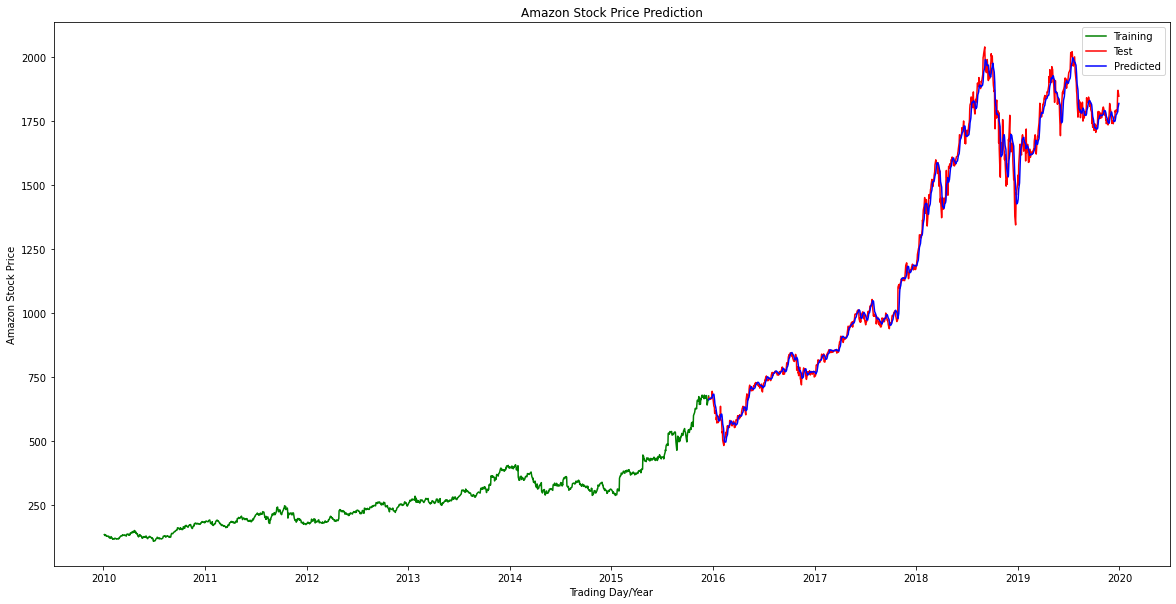

In [91]:
#for plotting simple LSTM prediction
train = new_data[:1500]
valid = new_data[1500:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], color = 'green', label = "Training")
plt.plot(valid['Close'], color = 'red', label = "Test")
plt.plot(valid['Predictions'], color = 'blue', label = "Predicted")
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Trading Day/Year')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()


****Bidirectional LSTM****


In [92]:
# create and fit the BiLSTM network
model = Sequential()
# Adding a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.5, input_shape=(x_train.shape[1],1))))
model.add(Bidirectional(LSTM(units=50, dropout=0.5)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1450/1450 - 33s - loss: 6.6504e-04 - 33s/epoch - 23ms/step


In [93]:
#predicting stock prices, using past 50 from the train data
inputs = new_data[len(new_data) - len(valid) - 50:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(50,inputs.shape[0]):
    X_test.append(inputs[i-50:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

C:\Users\iguku\AppData\Local\Temp/ipykernel_8940/3761217678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


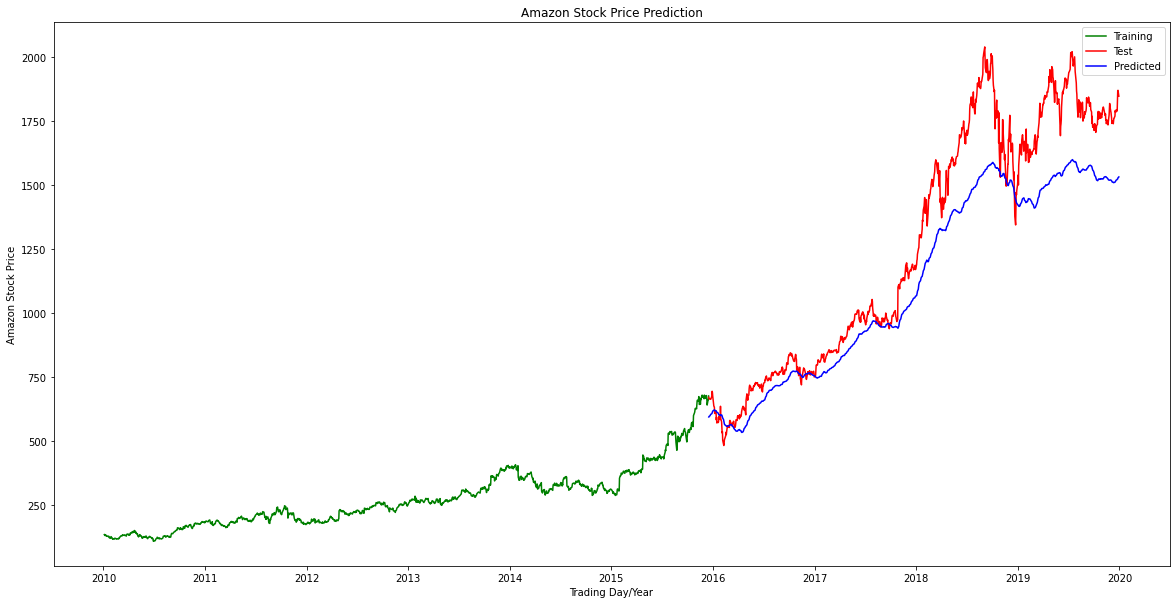

In [94]:
#for plotting
train = new_data[:1500]
valid = new_data[1500:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], color = 'green', label = "Training")
plt.plot(valid['Close'], color = 'red', label = "Test")
plt.plot(valid['Predictions'], color = 'blue', label = "Predicted")
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Trading Day/Year')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.show()